In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.stats import zscore, linregress
from pandas.plotting import scatter_matrix
from scipy import stats
import numpy as np
import seaborn as sns


def remove_outliers(df, threshold=3):
    # Initialize a boolean mask to keep track of rows to drop
    outlier_rows_mask = np.zeros(len(df), dtype=bool)

    # Iterate over each column
    for col in df.columns:
        # Skip the "t1" and "t2" columns
        if col == "t1" or col == "t2":
            continue

        # Calculate the mean and standard deviation of the column
        mean = df[col].mean()
        std = df[col].std()

        # Find outliers in this column
        outliers = (df[col] - mean).abs() > threshold * std

        # Mark rows with outliers in this column
        outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers)

    # Drop rows with outliers
    cleaned_df = df[~outlier_rows_mask]
    return cleaned_df

### Lets combined the names and types across Ameriflux and Fluxnetm


In [3]:
fluxnet_info = pd.read_csv("../data/EC/fluxnet/sites_info.csv")
ameriflux_info = pd.read_csv("../data/EC/Ameriflux/sites_info.tsv", delimiter="\t")
fluxnet_names = fluxnet_info["ID"].to_list()
fluxnet_types = fluxnet_info["type"].to_list()
ameriflux_names = ameriflux_info["Site ID"].to_list()
ameriflux_types = ameriflux_info["Vegetation Abbreviation (IGBP)"].to_list()

combined_names = list(set(ameriflux_names + fluxnet_names))
combined_types = []
for name in combined_names:
    if name in ameriflux_names and name in fluxnet_names:
        # Choose a type from either fluxnet_types or ameriflux_types
        combined_types.append(fluxnet_types[fluxnet_names.index(name)])
    elif name in ameriflux_names:
        combined_types.append(ameriflux_types[ameriflux_names.index(name)])
    else:
        combined_types.append(fluxnet_types[fluxnet_names.index(name)])

### Read the edddy covariance (EC) data into a pandas dataframe


In [5]:
combined_ec = []

for i in range(len(combined_names)):
    site_name = combined_names[i]
    site_type = combined_types[i]

    if site_name in ameriflux_names:
        file = glob.glob("../data/EC/Ameriflux/AMF_" + site_name + "*DD*")
    else:
        file = glob.glob("../data/EC/fluxnet/FLX_" + site_name + "*DD*")

    ec = pd.read_csv(file[0])
    ec.loc[:, "type"] = site_type
    ec.loc[:, "name"] = site_name
    ec.index = pd.to_datetime(ec["TIMESTAMP"], format="%Y%m%d")
    combined_ec.append(ec)
combined_ec = pd.concat(combined_ec)

In [15]:
MCD43_fluxnet = []
MCD15_fluxnet = []
MCD43_ameriflux = []
MCD15_ameriflux = []

# Loop over batches (#5) of downloaded data
for i in range(1, 5):
    refl_fluxnet = glob.glob(
        "../data/EC/fluxnet/sat_data/*batch" + str(i) + "*MCD43A4-061-results.csv"
    )
    sat_refl_fluxnet = pd.read_csv(refl_fluxnet[0])
    sat_refl_fluxnet.loc[:, "time"] = pd.to_datetime(sat_refl_fluxnet["Date"])
    sat_refl_fluxnet.set_index(sat_refl_fluxnet["Date"], inplace=True)
    MCD43_fluxnet.append(sat_refl_fluxnet)

    fpar_fluxnet = glob.glob(
        "../data/EC/fluxnet/sat_data/*batch" + str(i) + "*MCD15A3H-061-results.csv"
    )
    sat_fpar_fluxnet = pd.read_csv(fpar_fluxnet[0])
    sat_fpar_fluxnet.loc[:, "time"] = pd.to_datetime(sat_fpar_fluxnet["Date"])
    sat_fpar_fluxnet.set_index(sat_fpar_fluxnet["Date"], inplace=True)
    MCD15_fluxnet.append(sat_fpar_fluxnet)

    # Note all the ameriflux sites are in 4 batches
    if i < 5:
        refl_ameriflux = glob.glob(
            "../data/EC/Ameriflux/sat_data/*batch" + str(i) + "*MCD43A4-061-results.csv"
        )

        sat_refl_ameriflux = pd.read_csv(refl_ameriflux[0])
        sat_refl_ameriflux.loc[:, "time"] = pd.to_datetime(sat_refl_ameriflux["Date"])
        sat_refl_ameriflux.set_index(sat_refl_ameriflux["Date"], inplace=True)
        MCD43_ameriflux.append(sat_refl_ameriflux)

        fpar_ameriflux = glob.glob(
            "../data/EC/Ameriflux/sat_data/*batch"
            + str(i)
            + "*MCD15A3H-061-results.csv"
        )
        fpar_ameriflux = pd.read_csv(fpar_ameriflux[0])

        fpar_ameriflux.loc[:, "time"] = pd.to_datetime(fpar_ameriflux["Date"])
        fpar_ameriflux.set_index(fpar_ameriflux["Date"], inplace=True)
        MCD15_ameriflux.append(fpar_ameriflux)


refl_fluxnet = pd.concat(MCD43_fluxnet)
refl_fluxnet = refl_fluxnet.rename(columns={"ID": "name"})

fpar_fluxnet = pd.concat(MCD15_fluxnet)
fpar_fluxnet = fpar_fluxnet.rename(columns={"ID": "name"})

refl_ameriflux = pd.concat(MCD43_ameriflux)
refl_ameriflux = refl_ameriflux.rename(columns={"ID": "name"})
fpar_ameriflux = pd.concat(MCD15_ameriflux)
fpar_ameriflux = fpar_ameriflux.rename(columns={"ID": "name"})
combined_refl = []
combined_fpar = []

for name in combined_names:
    if name in ameriflux_names:
        selected_refl = refl_ameriflux[refl_ameriflux["name"] == name]
        selected_fpar = fpar_ameriflux[fpar_ameriflux["name"] == name]
    else:
        selected_refl = refl_fluxnet[refl_fluxnet["name"] == name]
        selected_fpar = fpar_fluxnet[fpar_fluxnet["name"] == name]

    combined_refl.append(selected_refl)
    combined_fpar.append(selected_fpar)

combined_refl = pd.concat(combined_refl)
combined_fpar = pd.concat(combined_fpar)

<Axes: >

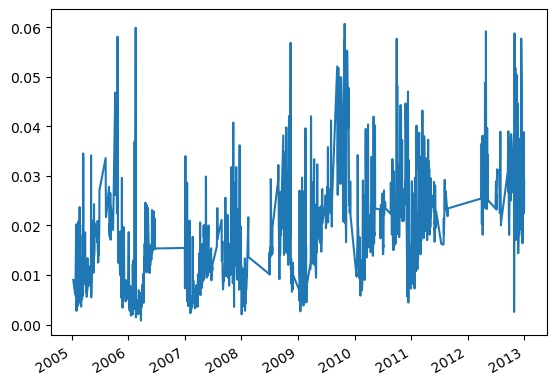

In [48]:
i = 10
name = combined_names[i]
type = combined_types[i]
ec_data = combined_ec[combined_ec["name"] == name]
# -------------Filter GPP------------------------
# The gap filled data is less than 20%
ec_data = ec_data[ec_data["NEE_VUT_REF_QC"] > 0.8]

# Uncertaninity in NEE is less than 3  C m−2 d−1
ec_data = ec_data[ec_data["NEE_VUT_REF_RANDUNC"] < 3]

# Difference between GPP day and night is less than 3 C m−2 d−1
# idx_good_gpp = abs(ec_data["GPP_DT_VUT_REF"] - ec_data["GPP_NT_VUT_REF"]) < 3
# gpp_day = ec_data["GPP_DT_VUT_REF"][idx_good_gpp]
# gpp_night = ec_data["GPP_NT_VUT_REF"][idx_good_gpp]
gpp_night = ec_data["GPP_NT_VUT_REF"]
gpp_day = ec_data["GPP_DT_VUT_REF"]

# # Take the mean of the day and night GPP
gpp = (gpp_day + gpp_night) / 2

# Make sure there is no negative GPP
gpp = gpp[gpp > 0]

par_qc = ec_data.loc[gpp.index, "PPFD_IN_QC"]
idx_good_par = par_qc[par_qc > 0.8]
par = ec_data.loc[idx_good_par.index, "PPFD_IN"]
gpp = gpp[par.index]
gpp = gpp.to_frame("gpp")
par = par.to_frame("par")

if par.empty:
    print(i, name, type, " Par Empty")

site_ec = pd.concat([gpp, par], axis=1)
site_refl = combined_refl[combined_refl["name"] == name]

site_refl.index = pd.to_datetime(site_refl.index, format="%Y-%m-%d")
site_refl = site_refl[site_refl.index.isin(site_ec.index)]

filtered_refl = site_refl[
    (
        site_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band1_MODLAND"]
        == "0b000"
    )
    & (
        site_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band2_MODLAND"]
        == "0b000"
    )
].copy()

site_red = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band1"]].rename(
    columns={"MCD43A4_061_Nadir_Reflectance_Band1": "red"}
)
site_nir = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band2"]].rename(
    columns={"MCD43A4_061_Nadir_Reflectance_Band2": "nir"}
)

site_fpar = combined_fpar[combined_fpar["name"] == name]
site_fpar.index = pd.to_datetime(site_fpar.index, format="%Y-%m-%d")

filtered_fpar = site_fpar[
    (site_fpar["MCD15A3H_061_FparLai_QC_MODLAND"] == "0b0")
    & (site_fpar["MCD15A3H_061_FparLai_QC_DeadDetector"] == "0b0")
    & (site_fpar["MCD15A3H_061_FparLai_QC_CloudState"] == "0b00")
    & (site_fpar["MCD15A3H_061_FparLai_QC_SCF_QC"].isin(["0b000", "0b001"]))
].copy()
if filtered_fpar.empty:
    print(i, name, type, " fpar")
fpar_tmp = filtered_fpar["MCD15A3H_061_Fpar_500m"]
site_fpar = fpar_tmp.resample("D").interpolate("linear")
site_fpar = site_fpar.to_frame("fpar")
site_fpar = site_fpar[site_fpar.index.isin(site_ec.index)]
site_df = (
    site_ec.merge(site_red, left_index=True, right_index=True)
    .merge(site_nir, left_index=True, right_index=True)
    .merge(site_fpar, left_index=True, right_index=True)
)
# Calculate the NDVI, NIRv, NIRvp, Fesc, and LUE
site_df.loc[:, "ndvi"] = (site_df["nir"] - site_df["red"]) / (
    site_df["nir"] + site_df["red"]
)
site_df.loc[:, "nirv"] = site_df["ndvi"] * site_df["nir"]
site_df.loc[:, "nirvp"] = site_df["nirv"] * site_df["par"]
site_df.loc[:, "fesc"] = site_df["nirv"] / site_df["fpar"]
site_df.loc[:, "lue"] = site_df["gpp"] / (site_df["par"] * site_df["fpar"])
site_df = site_df.replace([np.inf, -np.inf], np.nan).dropna()
cleaned_site_df = remove_outliers(site_df, 3).copy()
cleaned_site_df.loc[:, "name"] = name
cleaned_site_df.loc[:, "type"] = type